# Task 4 : Data Collection in the Wild

## Pre processing data

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tsfel
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

time = 10
offset = 100
folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

### Pre processing training data

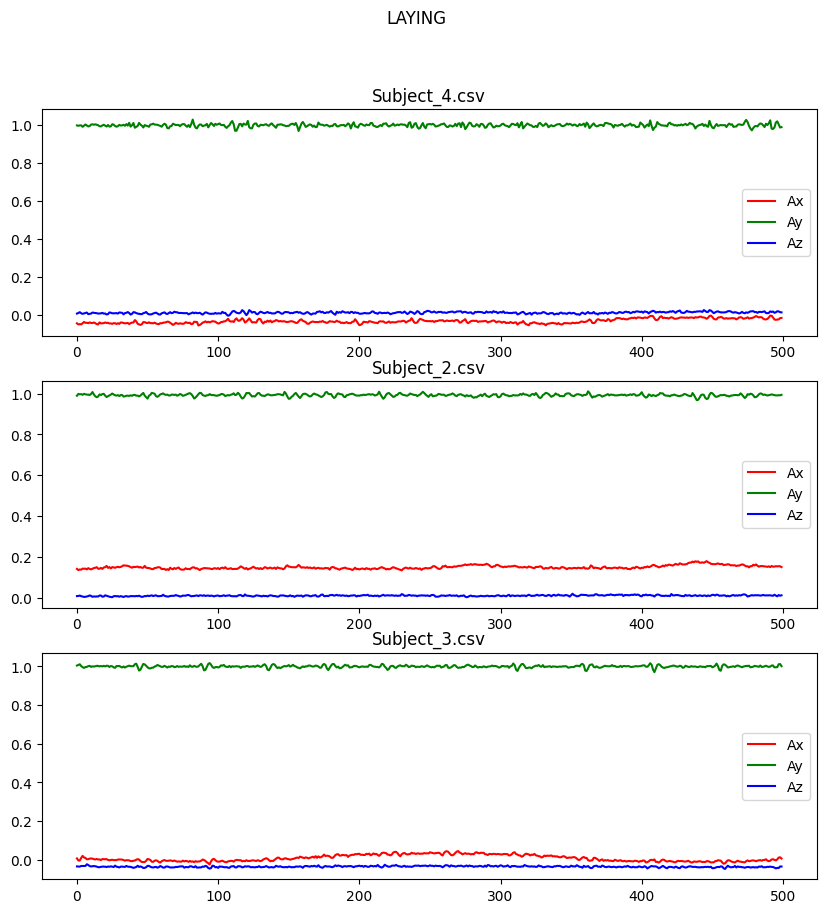

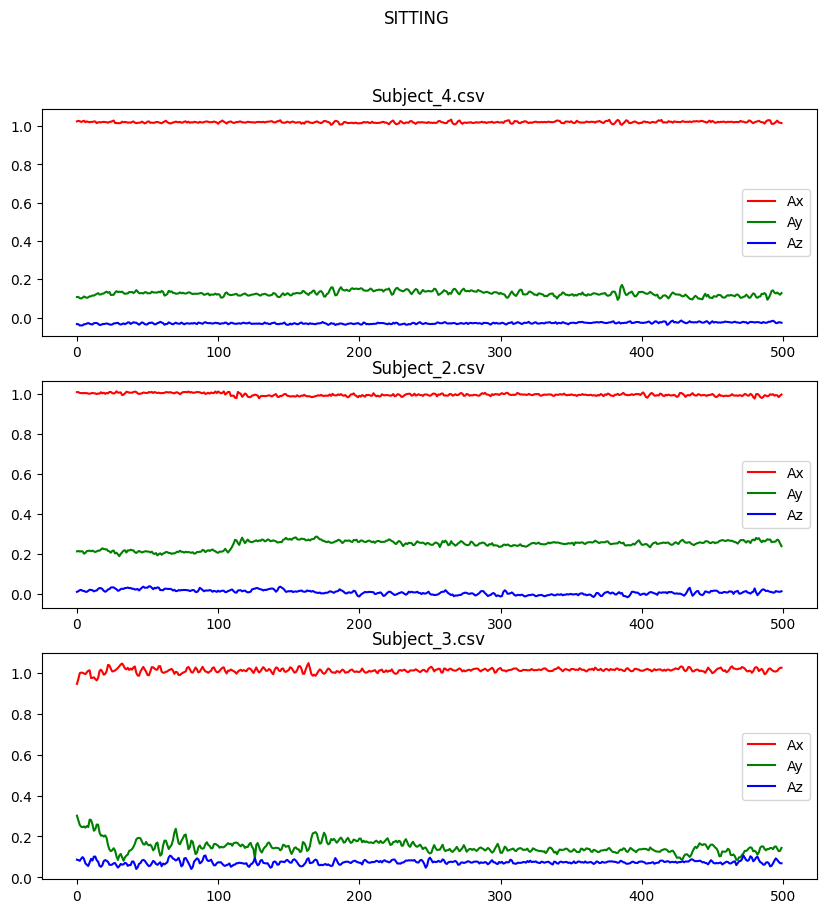

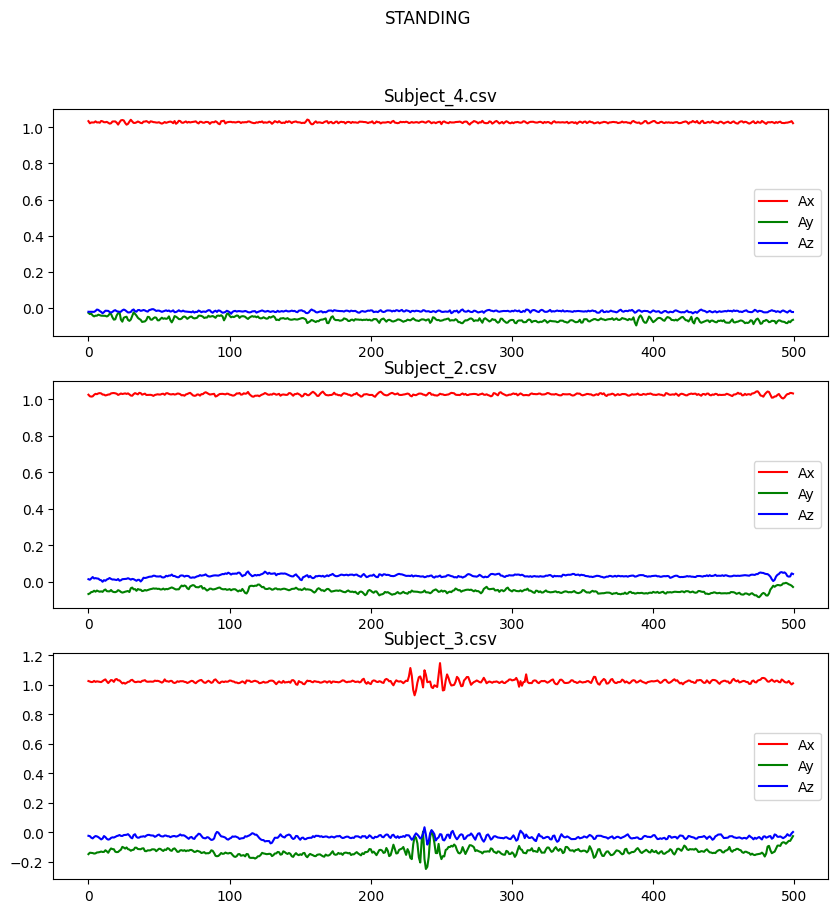

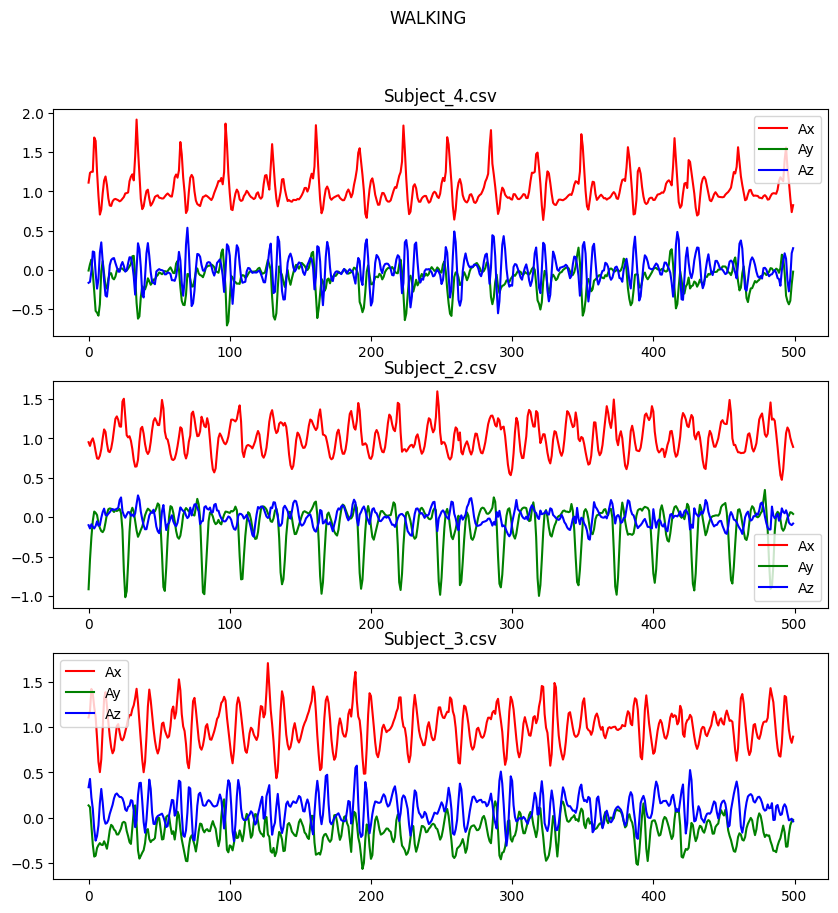

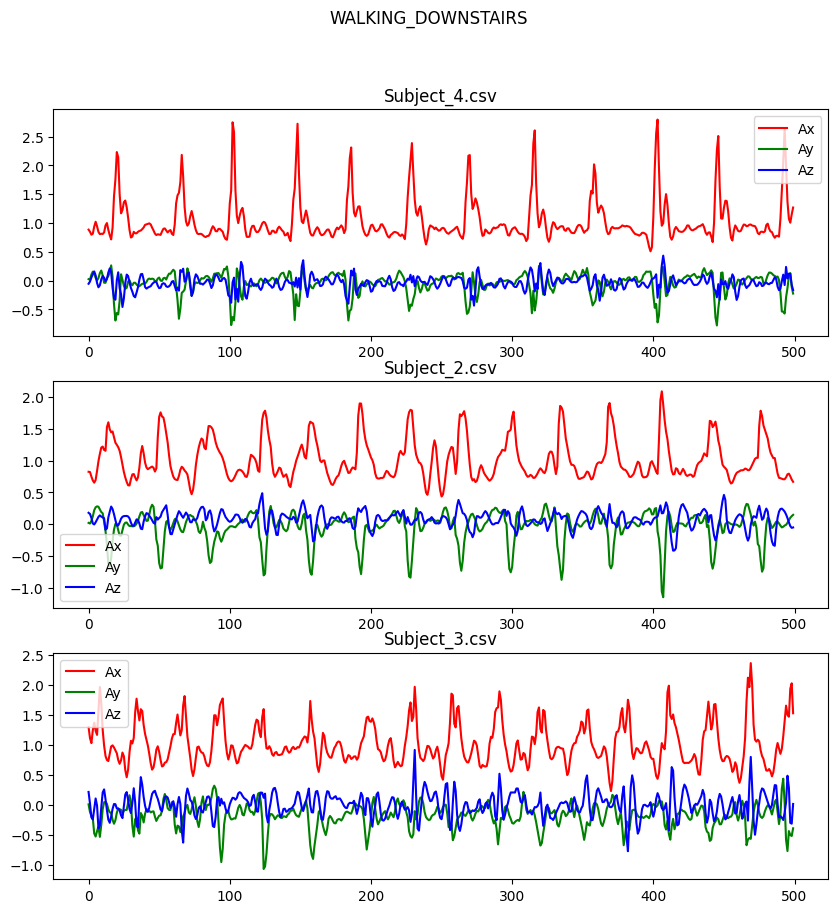

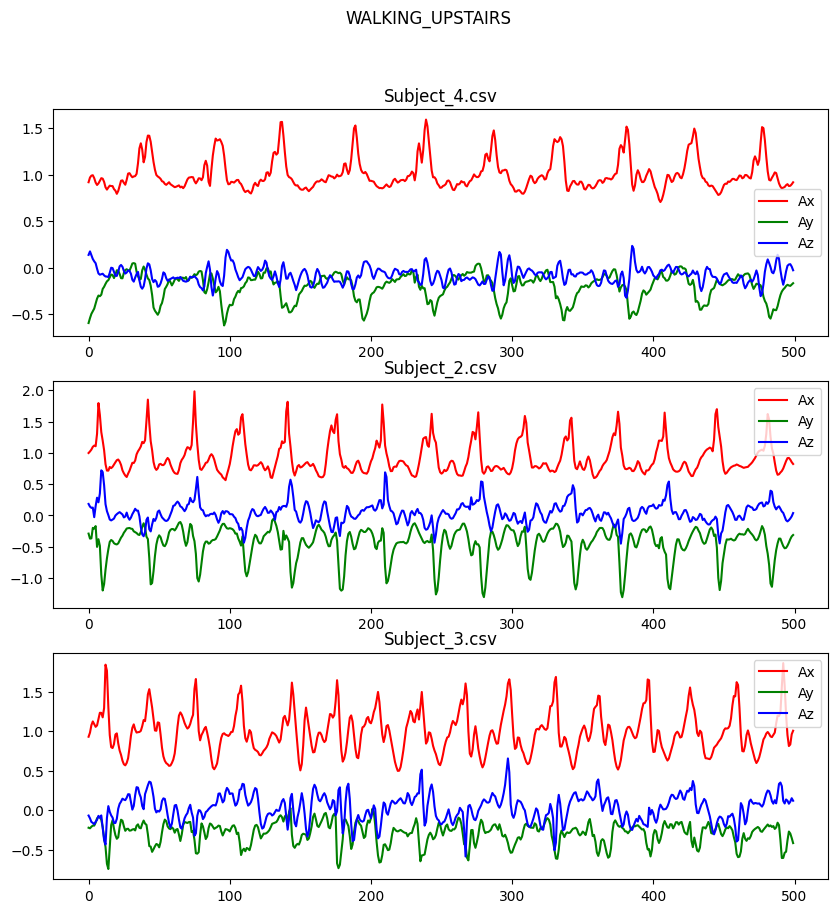

(18, 500, 3)
(18,)


In [3]:
X_train=[]
y_train=[]
# dataset_dir = os.path.join(combined_dir,"Train")
# count =0
for folder in folders:
    dataset_dir = os.path.join("Our_Combined", "Train", folder)
    plt.figure(figsize=(10,10))
    plt.suptitle(folder)
    i=1
    for file in os.listdir(dataset_dir):
        data = pd.read_csv(os.path.join(dataset_dir, file))
        data_reduced = data.drop(columns=['time', 'TgF'])
        # # switch order of columns
        data_reduced = data_reduced[['gFy', 'gFz', 'gFx']]
        data_reduced.columns = ['gFx', 'gFy', 'gFz']
        # downsample to 50 Hz from 400 Hz
        data = data_reduced.iloc[::8]
        # get 300 to 800
        data = data.iloc[300:800].reset_index(drop=True)

        X_train.append(data.values)
        y_train.append(classes[folder])

        # print(data.shape)
        plt.subplot(3,1,i)
        plt.plot(data['gFx'], label='Ax',color='red')
        plt.plot(data['gFy'], label='Ay',color='green')
        plt.plot(data['gFz'], label='Az',color='blue')
        plt.legend()
        plt.title(file)
        i+=1
    plt.show()

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

### Pre processing testing data

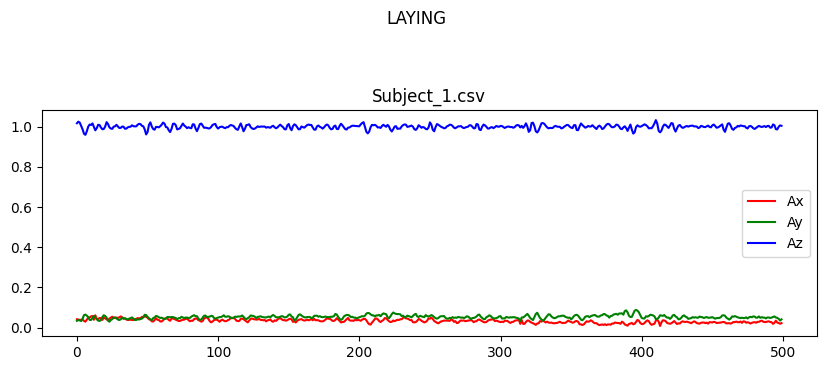

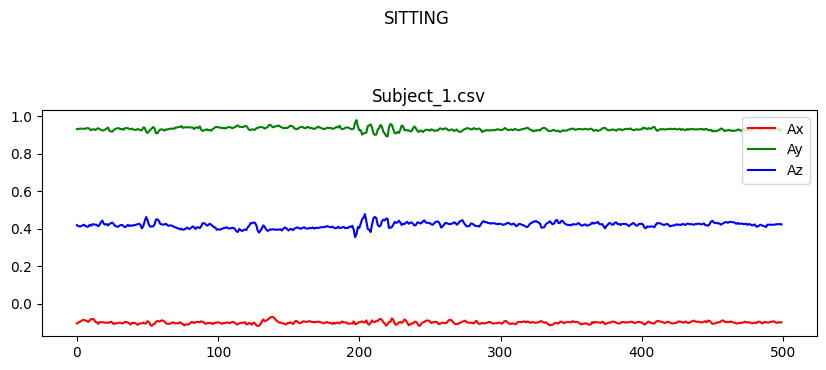

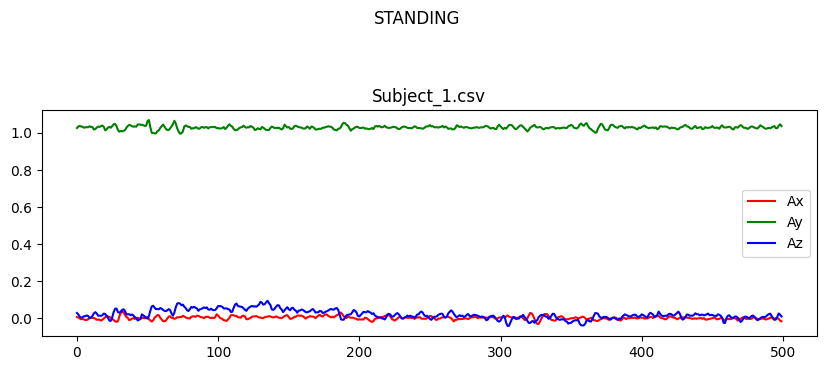

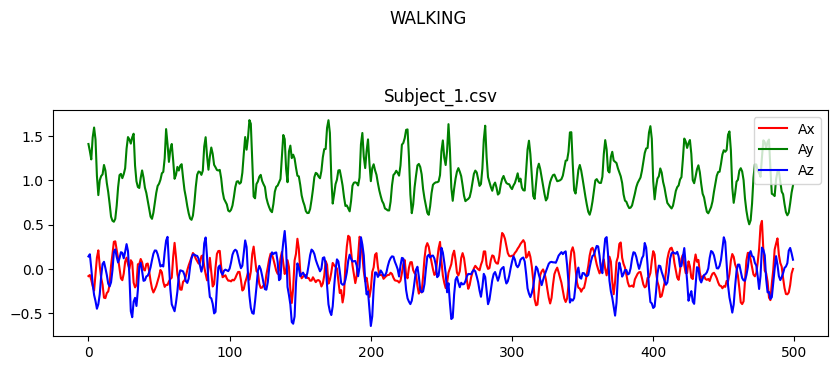

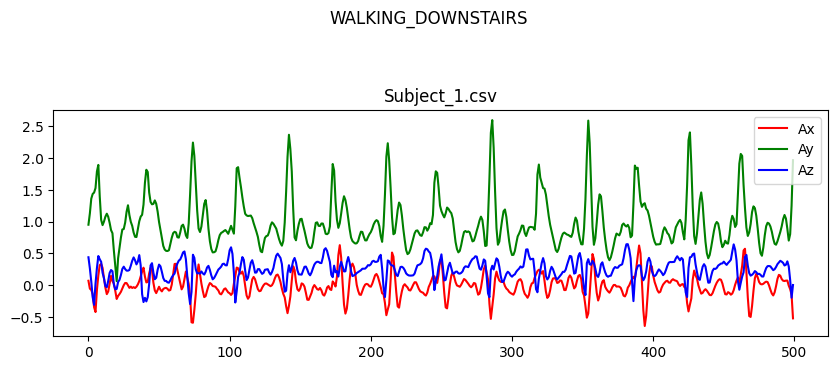

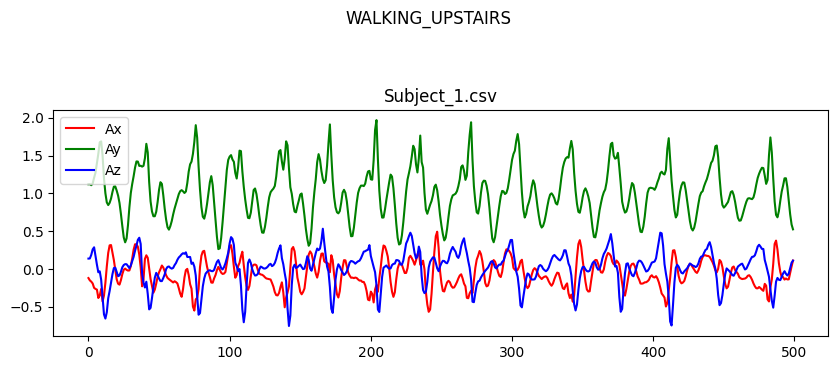

(6, 500, 3)
(6,)


In [4]:
X_test=[]
y_test=[]

for folder in folders:
    dataset_dir = os.path.join("Our_Combined","Test", folder)
    plt.figure(figsize=(10,10))
    plt.suptitle(folder)
    i=1
    
    for file in os.listdir(dataset_dir):
        data = pd.read_csv(os.path.join(dataset_dir, file))
        data_reduced = data.drop(columns=['time', 'TgF'])
        # # switch order of columns
        data_reduced = data_reduced[['gFy', 'gFz', 'gFx']]
        # downsample to 50 Hz from 400 Hz
        data = data_reduced.iloc[::8]
        # get 300 to 800
        data = data.iloc[300:800].reset_index(drop=True)
        # print(data.shape)
        X_test.append(data.values)
        y_test.append(classes[folder])

        plt.subplot(3,1,i)
        plt.plot(data['gFx'], label='Ax',color='red')
        plt.plot(data['gFy'], label='Ay',color='green')
        plt.plot(data['gFz'], label='Az',color='blue')
        plt.legend()
        plt.title(file)
        i+=1
    plt.show()

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape)
print(y_test.shape)

### Data Cleaning

In [5]:
# check for duplicated data, numpy doesnt have duplicated() function
def duplicates(data):
    return len(data) - len(np.unique(data, axis=0))

print("Number of duplicated samples in training data: ", duplicates(X_train))
print("Number of duplicated samples in testing data: ", duplicates(X_test))

Number of duplicated samples in training data:  0
Number of duplicated samples in testing data:  0


In [6]:
def null_values(data):
    return np.isnan(data).sum()

print("Number of NaN/Null values in training data: ", null_values(X_train))
print("Number of NaN/Null values in testing data: ", null_values(X_test))

Number of NaN/Null values in training data:  0
Number of NaN/Null values in testing data:  0


In [7]:
# Save the data
if not os.path.exists("./Our_Saved"):
    os.makedirs("./Our_Saved")

np.save("./Our_Saved/X_train.npy",X_train)
np.save("./Our_Saved/X_test.npy",X_test)
np.save("./Our_Saved/y_train.npy",y_train)
np.save("./Our_Saved/y_test.npy",y_test)

print("Data saved successfully!")

Data saved successfully!


## Question 1

Q1. Use the Decision Tree model trained on the UCI-HAR dataset to predict the activities that you performed. Report the accuracy, precision, recall and confusion matrix of the model. You have three version of UCI dataset you can use a)Raw data from accelerometer, b)TSFEL featurised data, c)Features provided by author. Choose which version to use, ensuring that your test data is similar to your training data. How did the model perform?

### Loading data

In [8]:
with open('./Models/dt1_model.sav', 'rb') as f:
    dt1 = pickle.load(f)
print(type(dt1))

with open('./Models/dt2_model.sav', 'rb') as f:
    dt2 = pickle.load(f)
print(type(dt2))

with open('./Models/dt3_model.sav', 'rb') as f:
    dt3 = pickle.load(f)
print(type(dt3))

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>


In [9]:
sys.path.insert(0, os.path.abspath('..'))
from latexify import latexify, format_axes
latexify()

# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
X_train = np.load('./Our_Saved/X_train.npy')
X_test = np.load('./Our_Saved/X_test.npy')
y_train = np.load('./Our_Saved/y_train.npy')
y_test = np.load('./Our_Saved/y_test.npy')

In [11]:
X_combined = np.concatenate((X_train, X_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

print(X_combined.shape)
print(y_combined.shape)

(24, 500, 3)
(24,)


In [12]:
X_dt1=np.hstack((X_combined[:,:,0],X_combined[:,:,1],X_combined[:,:,2]))

print(f"X: {X_dt1.shape}")
print(f"y: {y_combined.shape}")

X: (24, 1500)
y: (24,)


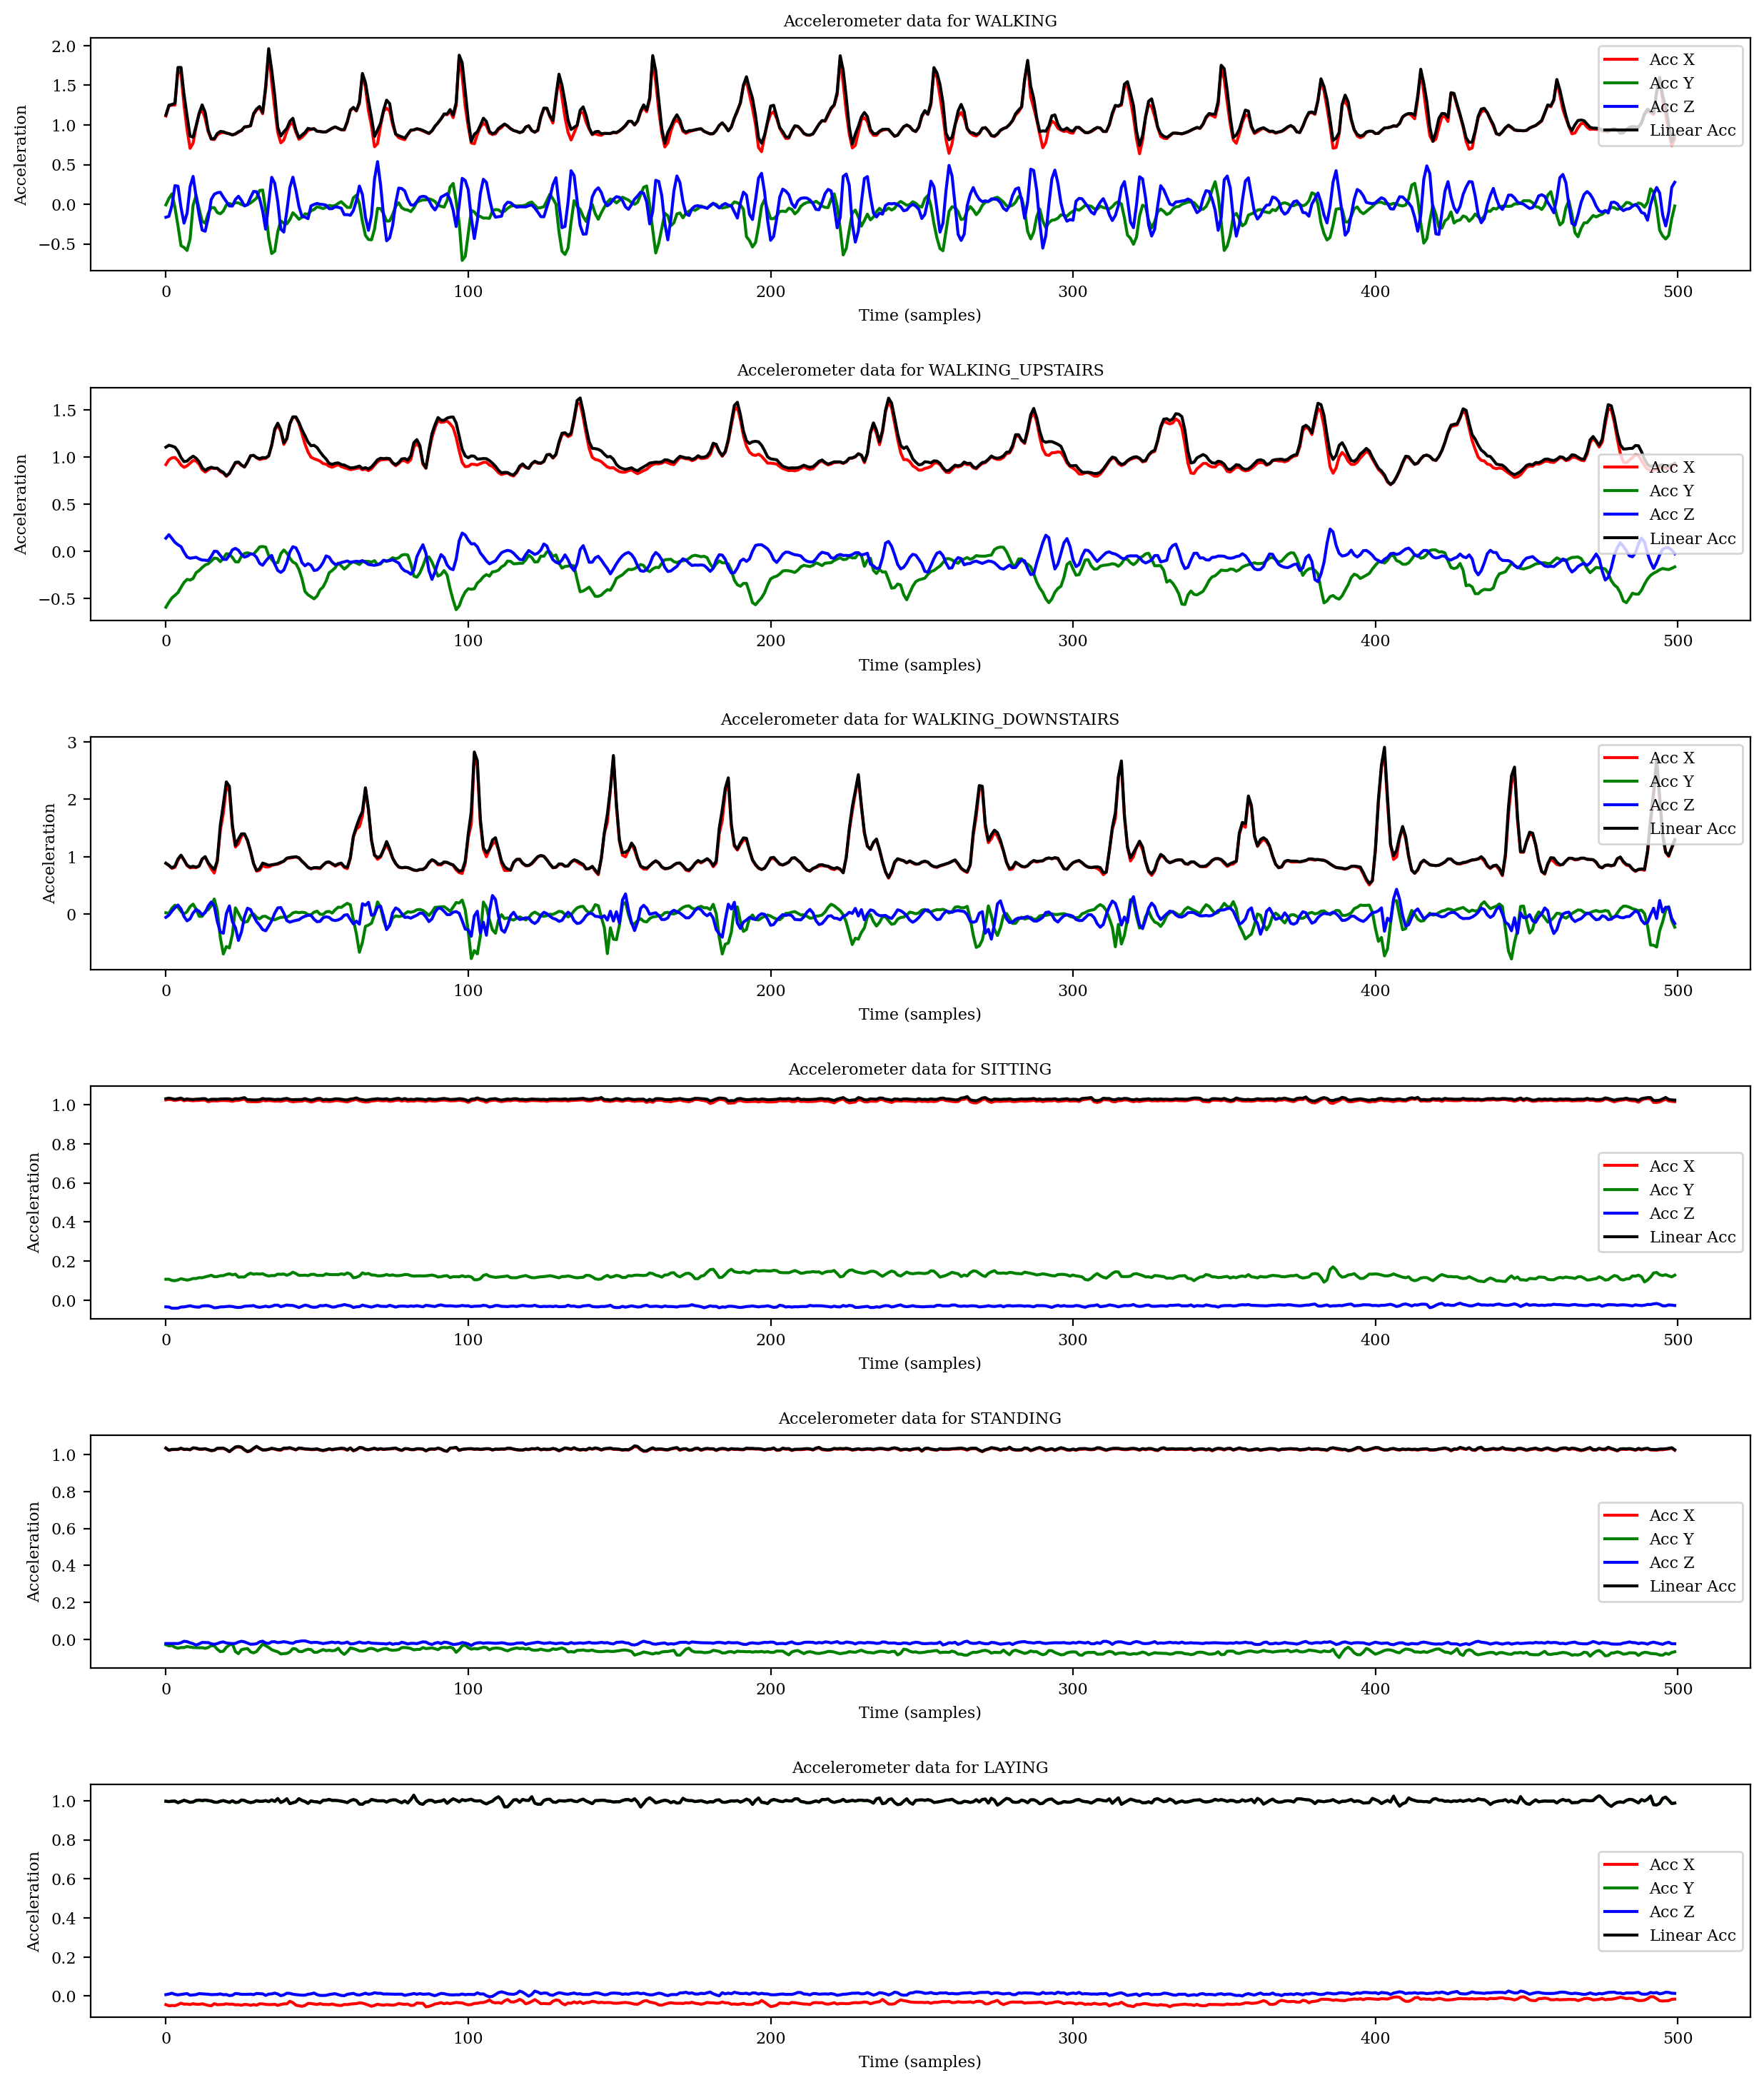

In [13]:
# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# mapping class labels to activity names , as provided in activity_labels.txt
classes = {1: "WALKING", 2: "WALKING_UPSTAIRS", 3: "WALKING_DOWNSTAIRS", 4: "SITTING", 5: "STANDING", 6: "LAYING"}


activity_samples = {}# stores one sample from each activity class
for activity_class, activity_name in classes.items():
    activity_samples[activity_name] = X_combined[y_combined == activity_class][0]

# Set up the figure and gridspec
fig = plt.figure(figsize=(15, 18))
gs = gridspec.GridSpec(len(classes), 1, hspace=0.5)

# Plot each activity's accelerometer data along with the linear acceleration
for i, (activity_name, sample) in enumerate(activity_samples.items()):
    ax = fig.add_subplot(gs[i, 0])
    
    # Calculate linear acceleration
    linear_acc = np.sqrt(np.sum(sample**2, axis=1))
    
    # Plot the x, y, z acceleration data
    ax.plot(sample[:, 0], label='Acc X', color='red')
    ax.plot(sample[:, 1], label='Acc Y', color='green')
    ax.plot(sample[:, 2], label='Acc Z', color='blue')
    
    # Plot the linear acceleration
    ax.plot(linear_acc, label='Linear Acc', color='black')
    
    ax.set_title(f"Accelerometer data for {activity_name}")
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Acceleration")
    ax.legend()

plt.show()

### Raw Data Decision Tree

In [14]:
from sklearn import metrics

y_dt1_pred = dt1.predict(X_dt1)

y_combined = np.array(y_combined)
y_dt1_pred = np.array(y_dt1_pred)

# Calculate metrics
accuracy = metrics.accuracy_score(y_combined, y_dt1_pred)
precision = metrics.precision_score(y_combined, y_dt1_pred, average='macro')
recall = metrics.recall_score(y_combined, y_dt1_pred, average='macro')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

# Create and display comparison DataFrame
comparison_df = pd.DataFrame({
    'True Label': y_combined,
    'Predicted Label': y_dt1_pred
})

Accuracy:  0.5416666666666666
Precision:  0.5416666666666666
Recall:  0.5416666666666666


### TSFEL Decision Tree

In [15]:
# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_dt2 = tsfel.time_series_features_extractor(cfg, X_combined, verbose=1, fs=50)

print(f"X: {X_dt2.shape}")
print(f"y: {y_combined.shape}")

*** Feature extraction started ***



*** Feature extraction finished ***
X: (24, 1152)
y: (24,)


### UCI HAR Data

We cant use the decision tree modelled on 561 feature data provided by the author, because we have only measured x, y, z accelerations and we dont have access to all the other features provided by the author.

## Question 2

Q2. Use the data you collected to predict the activities that you performed. Decide whether to apply preprocessing and featurization, and if so, choose the appropriate methods. How did the model perform?

### Training the tree directly on the collected data

In [16]:
X_train_stacked=np.hstack((X_train[:,:,0],X_train[:,:,1],X_train[:,:,2]))
X_test_stacked=np.hstack((X_test[:,:,0],X_test[:,:,1],X_test[:,:,2]))

print(f"X_train_stacked: {X_train_stacked.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {X_test_stacked.shape}")
print(f"y_test: {y_test.shape}")

dt1=DecisionTreeClassifier(random_state=42)
dt1.fit(X_train_stacked,y_train)

y_pred_dt1=dt1.predict(X_test_stacked)

print("Accuracy: ",sklearn.metrics.accuracy_score(y_test, y_pred_dt1))
print("Precision: ",sklearn.metrics.precision_score(y_test, y_pred_dt1,average='macro'))
print("Recall: ",sklearn.metrics.recall_score(y_test, y_pred_dt1,average='macro'))

X_train_stacked: (18, 1500)
y_train: (18,)
x_test: (6, 1500)
y_test: (6,)
Accuracy:  0.5
Precision:  0.4166666666666667
Recall:  0.5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Applying TSFEL featurization and PCA on the data

In [17]:
# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train, verbose=1,fs =50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test, verbose=1,fs =50)

print(f"X_train_tsfel: {X_train_tsfel.shape}")
print(f"X_test_tsfel: {X_test_tsfel.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")



# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train_tsfel, threshold=0.95)
X_train_tsfel.drop(corr_features, axis=1, inplace=True)
X_test_tsfel.drop(corr_features, axis=1, inplace=True)
print("Shape of train data after removing correlated features:",X_train_tsfel.shape)
print("Shape of test data after removing correlated features:",X_test_tsfel.shape)

# Remove low variance features
selector = VarianceThreshold(threshold = 0.1) # default is 0
X_train_tsfel = selector.fit_transform(X_train_tsfel)
X_test_tsfel = selector.transform(X_test_tsfel)
print("\nShape of train data after removing low variance features:",X_train_tsfel.shape)
print("Shape of test data after removing low variance features:",X_test_tsfel.shape)

# Normalising Features
scaler = StandardScaler()
X_train_tsfel_scaled = scaler.fit_transform(X_train_tsfel)
X_test_tsfel_scaled = scaler.transform(X_test_tsfel)

# Applying PCA
tsfel_pca = PCA(n_components=5)
X_train_tsfel_pca = tsfel_pca.fit_transform(X_train_tsfel_scaled)
X_test_tsfel_pca = tsfel_pca.transform(X_test_tsfel_scaled)

print("Training data shape after PCA: ",X_train_tsfel_pca.shape)
print("Testing data shape after PCA: ",X_test_tsfel_pca.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
X_train_tsfel: (18, 1152)
X_test_tsfel: (6, 1152)
y_train: (18,)
y_test: (6,)
Shape of train data after removing correlated features: (18, 519)
Shape of test data after removing correlated features: (6, 519)

Shape of train data after removing low variance features: (18, 100)
Shape of test data after removing low variance features: (6, 100)
Training data shape after PCA:  (18, 5)
Testing data shape after PCA:  (6, 5)


### Training the tree on processed data

In [18]:
dt3=DecisionTreeClassifier(random_state=42)
dt3.fit(X_train_tsfel_pca,y_train)

y_tsfel_pca_pred=dt3.predict(X_test_tsfel_pca)

print("Accuracy: ",sklearn.metrics.accuracy_score(y_test, y_tsfel_pca_pred))
print("Precision: ",sklearn.metrics.precision_score(y_test, y_tsfel_pca_pred,average='macro'))
print("Recall: ",sklearn.metrics.recall_score(y_test, y_tsfel_pca_pred,average='macro'))

Accuracy:  0.6666666666666666
Precision:  0.5555555555555555
Recall:  0.6666666666666666


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Question 3

Q3. Use the Few-Shot prompting method using UCI-HAR dataset to predict the activities that you performed. Ensure that both your examples and test query undergo similar preprocessing. How did the model perform?